In [1]:
import scipy.io
import pandas as pd
import numpy as np

from math import log2
from dataclasses import dataclass, field

from functools import partial
from queue import deque
from enum import Enum
from collections import deque

from typing import *
from operator import *

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.datasets import *

import graphviz
#mat = scipy.io.loadmat('/Users/scott/projects/research-projects/tree_diff/input/twitter/influenza_outbreak_dataset.mat')

## Decision Tree Features
* ~Handle multiclass/binary~
* Binary or multple splits: Binary only 
* Choice of stopping criteria
* Choice of evaluation measure 
* Choice of splitting criteria 
* Choice of pruning strategy 
* Opaque rules

In [2]:
a = load_iris()
X = a.data
y = a.target

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.5)

# Simple Decision tree

## Data classes 

In [3]:
class Operator(str, Enum):
    EQ = "=="
    LT = "<"
    GT = ">"
    LE = "<="
    GE = ">="
    NE = "!="
    
    @property
    def op(self):
        return {self.EQ: eq, 
                self.LT: lt, 
                self.LE: le, 
                self.GE: ge,
                self.NE: ne,                
                self.GT: gt}[self]

@dataclass
class Condition:
    attribute: str
    attribute_pos: int
    operator: Operator
    threshold: float

    def __repr__(self):
        return str(self)

    def __str__(self):
        return f"{self.attribute} {self.operator} {self.threshold}"
            
    def fire(self, x):        
        return self.operator.op(x[self.attribute_pos], self.threshold)
    
@dataclass
class Split:
    score: float 
    attribute_pos: int
    ids: Tuple[float]
    operations: List[Tuple[Operator, float]]
        
@dataclass            
class DecisionNode:
    label: str
    node_id: int
    value: List[int]    
    impurity: float = 0.0
    parent: 'Node' = None
    children: List['Node'] = field(default_factory=list)
    conditions: List[Condition] = field(default_factory=list)    
        
    def walk(self, callback):
        callback(self)
        for n in self.children:
            n.walk(callback)        
        
    def add_child(self, condition, node):
        self.conditions.append(condition)
        node.parent = self
        self.children.append(node)
    
    def predict(self, x):
        stack = deque()
        stack.append(self)
        node = self

        while not node.is_leaf():
            node = stack.pop()

            for i, cond in enumerate(node.conditions):
                if cond.fire(x):
                    stack.append(node.children[i])

        return node.label            
    
    def is_leaf(self):
        return not self.children
    
    def is_root(self):
        return not self.parent
    
    def plot(self):
        dot = graphviz.Digraph('tree', comment='Decision Tree')  

        def update_dot(dot, node):
            dot.node(f"{node.node_id}", f"Node_{node.node_id}\nImpurity: {node.impurity:0.3f}\nLabel: {node.label}\nValue: {node.value}\nSamples: {sum(node.value)}")
            if node.parent:
                cond = node.find_to_condition()
                dot.edge(f"{node.parent.node_id}" , f"{node.node_id}", str(cond))
        
        update_dot_partial = partial(update_dot, dot)        
        self.walk(update_dot_partial)
        return dot
    
    def find_to_condition(self):
        if self.is_root():
            return None
        else:            
            index = -1
            for i, node in enumerate(self.parent.children):
                if node.node_id == self.node_id:
                    index = i
            if index < 0:
                raise ValueError("Incorrect tree")
            return self.parent.conditions[index]
                             
    def __str__(self):
        return f"Node_{self.node_id}"     
    
    def get_feature(self):
        if not self.is_leaf():
            return self.conditions[0].attribute
    
    def get_nodes(self):
        node_list = []
        self.walk(lambda n: node_list.append(n))
        return node_list
    
    def get_features(self):
        l = []
        for n in self.get_nodes():
            feature = n.get_feature()
            if feature is not None:
                l.append(feature)
        return list(set(l))
            
        

In [4]:
lt(3,4)

True

In [5]:
node = DecisionNode(
    label = 'Root',
    node_id = 101,
    value = [500,100],    
    impurity = 0.23,
    parent = None,
    children = [],
    conditions=[Condition("height", 0, Operator.LT, 2.0)]
)        

In [6]:
node.is_root()

True

In [7]:
node2 = DecisionNode(
    label = 'Root',
    node_id = 102,
    value = [500,100],    
    impurity = 0.23,
    parent = node,
    children = [],
    conditions=[Condition("age", 1, Operator.LT, 60)]
)    

In [8]:
node.children = [node2]

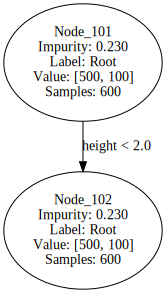

In [9]:
node.plot()

## Utility functions

In [10]:
def stopping_criteria(tree_depth, **kwargs):
    max_depth = kwargs.pop('max_depth', -1)
    if tree_depth >= max_depth:
        return True        
    return False    


def gini_impurity(y):
    counts = Counter(y)
    total = sum(counts.values())
    return round(1 - sum(map(lambda x: (x / total) ** 2, counts.values())), 3)


def entropy_impurity(y):
    counts = Counter(y)
    total = sum(counts.values())
    return - sum(map(lambda x: (x / total) * log2 (x / total), counts.values()))    
    

def evaluation_measure(groups: Tuple, measure):
    N = sum(map(len,groups))    
    return sum(map(lambda x: len(x) / N * measure(x), groups))
    
    
def calculate_current_depth(current_node):
    depth_counter = 0
    parent_node = current_node.parent    
    while parent_node:
        depth_counter += 1
        parent_node = parent_node.parent
    return depth_counter

def count_values(array, values):
    return [np.count_nonzero(array == i) for i in sorted(values)]        
        
def find_best_split(X, y, **kwargs):     
    split = Split(1,-1,(),())    
    measure = kwargs.pop("measure", gini_impurity)
    
    # Loop over attributes
    for i in range(0, X.shape[1]):
        x_s = X[:, i]

        # Try each unique value (inefficient for numerical values)
        # TODO: All split conditions are in the dataset unlike in CART       
        for threshold in np.unique(x_s):
            
            # TODO: Support non binary splits
            ids = (x_s <= threshold, x_s > threshold)
            operations = [(Operator.LE, threshold), (Operator.GT, threshold)]
            
            y_values = [y[i] for i in ids]            
            score = evaluation_measure(y_values, measure)

            # Find smallest gain, use 
            if score < split.score:
                split = Split(score, i, ids, operations)

    return split

## Grow a decision tree

In [11]:
def grow_tree(X, y, **kwargs):
    attribute_types = list(map(str, X.dtypes))
    column_name = X.columns
    X = X.to_numpy()
    node_counter = 1    
    stack = deque()
    
    # Set up decision tree
    classes = np.unique(y)
    counts = count_values(y, classes)
    tree = DecisionNode(max(y), node_counter, counts, gini_impurity(y))
    stack.append((tree, X, y))

    while len(stack) != 0:
        current_node, parent_X, parent_y = stack.pop()            

        # Stop once reached max depth branching
        current_depth = calculate_current_depth(current_node)
        if stopping_criteria(current_depth, **kwargs):
            continue
        
        # Stop branching if node contains a single class
        values = np.unique(parent_y)            
        if len(values) < 2:
            continue
        
        
        # Determine best attribute and split
        split = find_best_split(parent_X, parent_y, **kwargs)

        # Update tree with new split
        for cond, split_ids in zip(split.operations, split.ids):        
            new_y = parent_y[split_ids]
            new_X = parent_X[split_ids]            

            # Ensure new node is processed later
            counts = count_values(new_y, classes)
            if len(counts) == 0:
                continue 
            
            condition = Condition(column_name[split.attribute_pos], 
                                  split.attribute_pos, 
                                  cond[0],
                                  cond[1])
             
            label = classes[np.argmax(counts)]
            node_counter += 1
            
            score = gini_impurity(new_y)
 
            new_node = DecisionNode(label, node_counter, counts, score)
            current_node.add_child(condition, new_node)

            stack.append((new_node, new_X, new_y))
            
    return tree        
tree = grow_tree(pd.DataFrame(X_train, columns=["F1", "F2", "F3", 'F4']), y_train, max_depth=2, min_samples_split=2)
#tree.plot()

# Sample datasets

In [12]:
datasets = [load_iris, load_breast_cancer, load_digits, load_wine]

for func_data in datasets:
    d = func_data()
    X = d.data
    y = d.target
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.5)
    
    tree = grow_tree(pd.DataFrame(X_train), y_train, max_depth=2)            
    y_pred_cust = [tree.predict(X_test[i]) for i in range(0, X_test.shape[0])]
    
    sklearn_dt = DecisionTreeClassifier(max_depth=2).fit(X_train, y_train)    
    y_pred = sklearn_dt.predict(X_test)
    
    print(f"Sklearn Decision Tree:{accuracy_score(y_test, y_pred):0.2f}, Custom Tree:{accuracy_score(y_test, y_pred_cust):0.2f}, {func_data.__name__}")
    

Sklearn Decision Tree:0.89, Custom Tree:0.89, load_iris
Sklearn Decision Tree:0.94, Custom Tree:0.94, load_breast_cancer
Sklearn Decision Tree:0.29, Custom Tree:0.29, load_digits
Sklearn Decision Tree:0.88, Custom Tree:0.83, load_wine


# Regrowth algorithm

In [13]:
d = load_digits()
X = d.data
y = d.target
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.5)

tree = grow_tree(pd.DataFrame(X_train), y_train, max_depth=3)            
y_pred_cust_train = [tree.predict(X_train[i]) for i in range(0, X_train.shape[0])]
y_pred_cust = [tree.predict(X_test[i]) for i in range(0, X_test.shape[0])]

f"Train: {accuracy_score(y_train, y_pred_cust_train):0.2f}, Validation: {accuracy_score(y_test, y_pred_cust):0.2f}" 

'Train: 0.52, Validation: 0.47'

In [14]:
budget = 5
base_accuracy = accuracy_score(y_train, y_pred_cust_train)
base_tree = tree

leafs = []
tree.walk(lambda x: leafs.append(x))
N = sum(tree.value)
for x in sorted(leafs, key=lambda x: x.impurity, reverse=False):
    print(x.node_id, x.impurity, x.label, x.value, sum(x.value)/N)

8 0.026 0 [76, 0, 1, 0, 0, 0, 0, 0, 0, 0] 0.08574610244988864
15 0.066 5 [1, 0, 0, 2, 0, 85, 0, 0, 0, 0] 0.09799554565701558
13 0.105 6 [0, 0, 5, 0, 0, 0, 85, 0, 0, 0] 0.10022271714922049
4 0.177 0 [76, 1, 1, 0, 5, 0, 0, 0, 0, 1] 0.0935412026726058
9 0.449 4 [0, 1, 0, 0, 5, 0, 0, 0, 0, 1] 0.0077951002227171495
11 0.465 6 [1, 4, 5, 0, 24, 2, 88, 1, 0, 0] 0.13919821826280623
12 0.504 4 [1, 4, 0, 0, 24, 2, 3, 1, 0, 0] 0.03897550111358575
10 0.622 5 [1, 18, 22, 8, 6, 89, 3, 4, 1, 1] 0.17037861915367483
6 0.679 9 [7, 14, 1, 69, 1, 9, 0, 1, 10, 86] 0.22048997772828507
2 0.757 5 [2, 22, 27, 8, 30, 91, 91, 5, 1, 1] 0.30957683741648107
14 0.782 2 [0, 18, 22, 6, 6, 4, 3, 4, 1, 1] 0.07238307349665925
7 0.82 7 [1, 51, 53, 12, 46, 1, 3, 85, 74, 12] 0.37639198218262804
5 0.86 9 [8, 65, 54, 81, 47, 10, 3, 86, 84, 98] 0.5968819599109132
3 0.875 9 [84, 66, 55, 81, 52, 10, 3, 86, 84, 99] 0.6904231625835189
1 0.899 9 [86, 88, 82, 89, 82, 101, 94, 91, 85, 100] 1.0


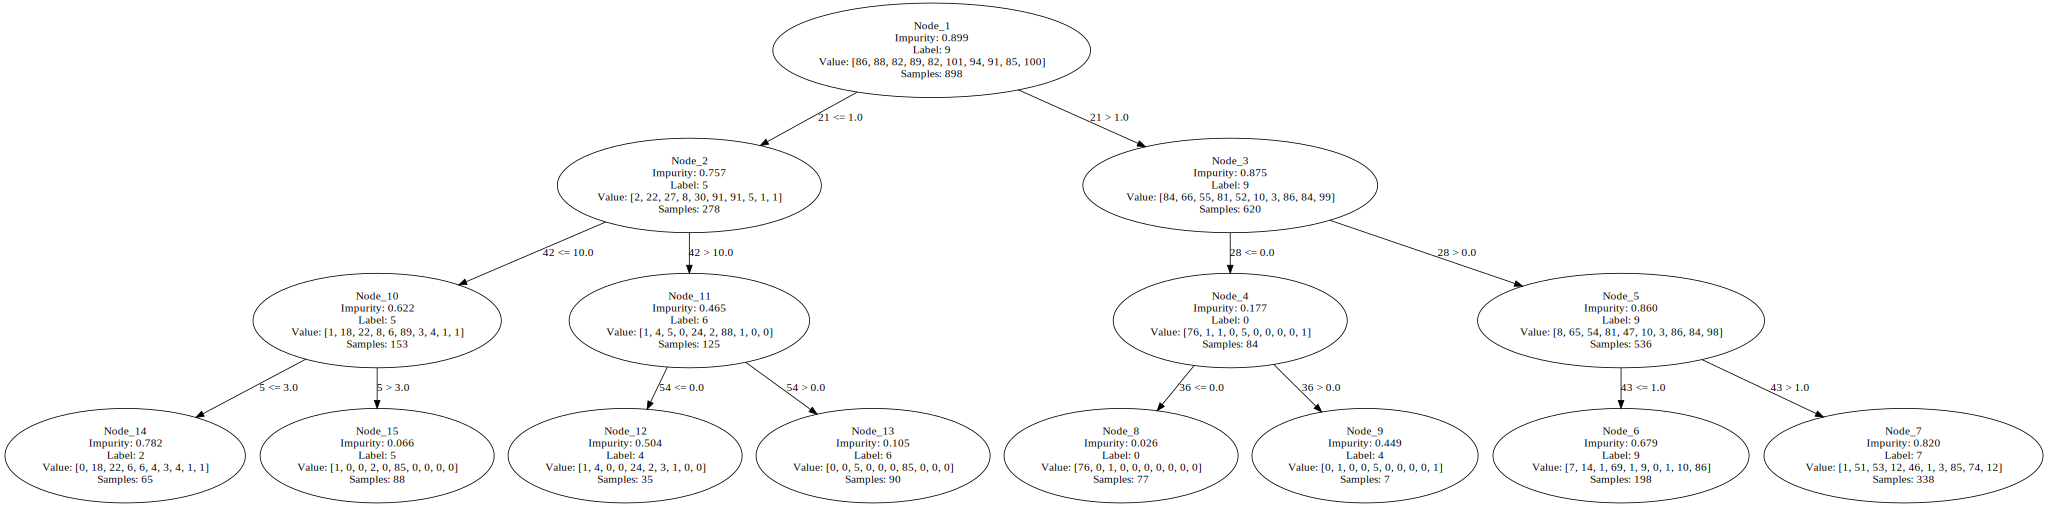

In [15]:
tree.plot()

In [16]:
tree.children[-1].conditions[0].attribute

28

In [17]:
tree.get_features()

[36, 5, 42, 43, 21, 54, 28]

In [18]:
tree.conditions[0].attribute

21

In [19]:
def get_rules(tree, feature_names, class_names):
    tree_ = tree
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " then "
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules

In [20]:
X

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

In [21]:
iris = datasets.load_iris()
X = iris.data
y = iris.target


AttributeError: 'list' object has no attribute 'load_iris'

In [ ]:
from sklearn import datasets


In [ ]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

In [ ]:
iris.feature_names

In [ ]:
iris.target_names